In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import time
from textblob import TextBlob
import pycountry

In [3]:
data = pd.read_csv('games.csv',encoding='MS932')

In [4]:
# Convert price vnd to usd
data['price'] = round(data['price'].str.replace(',', '').replace('free','0').astype(float) / 23000, 2)
# Convert string to float
data['rating_count'] = data['rating_count'].str.replace(',', '').astype(float)
# Create is_free column base on price
data['is_free'] = np.where(data['price'] != 0, True, False)
# Convert ad_supported to bool
data['ad_supported'] = data['ad_supported'].fillna(0).astype(bool)
# Convert editors_choice to bool
data['editors_choice'] = data['editors_choice'].astype(bool)
# Fill nan of size
data['size'] = data['size'].fillna("Varies with device")
# drop nan of content_rating
data = data[data['content_rating'].notna()]

In [5]:
data.head()

,id,title,url,category,avg_rating,rating_count,price,developer_name,developer_url,description,summary,min_installs,editors_choice,size,android_version,content_rating,ad_supported,released,is_free
0,aasuited.net.word,Dingbats - Between the lines,https://play.google.com/store/apps/details?id=...,Trivia,4.6,22871.0,0.00,Romain Lebouc,https://play.google.com/store/apps/developer?i...,"One puzzle, one phrase : try to identity the m...",Can you guess the famous idioms from the drawi...,1000000.0,False,21M,4.1,Everyone,True,"Mar 21, 2015",False
1,agamz.logic,Logic Puzzles - Brain Fun,https://play.google.com/store/apps/details?id=...,Word,4.0,919.0,3.00,Egghead Games LLC,https://play.google.com/store/apps/dev?id=8905...,Logic grid puzzles like those in Dell magazine...,"The highest rated logic grid puzzle app, with ...",10000.0,False,3.9M,4.0.3,Everyone,False,"Oct 9, 2012",True
2,age.of.civilizations2.jakowski.lukasz,Age of History II,https://play.google.com/store/apps/details?id=...,Strategy,4.2,21837.0,2.39,?ukasz Jakowski,https://play.google.com/store/apps/dev?id=4635...,Age of History II is a grand strategy wargame ...,AoH2 is a grand strategy wargame that is simpl...,100000.0,False,140M,4.0,Everyone,False,"Dec 4, 2018",True
3,air.air.RedSunPremium,Redsun RTS Premium,https://play.google.com/store/apps/details?id=...,Strategy,3.6,1571.0,1.65,Digital Garbage,https://play.google.com/store/apps/developer?i...,Redsun RTS is a prime example of the genre cla...,RedSun Real Time Strategy - strategy for the f...,10000.0,False,Varies with device,4.4,Teen,False,"Jun 25, 2015",True
4,air.air.SugarSugar,"sugar, sugar",https://play.google.com/store/apps/details?id=...,Puzzle,4.5,1616.0,1.96,Bart Bonte,https://play.google.com/store/apps/dev?id=6731...,Draw with your finger on the screen to direct ...,Draw to get enough sugar in all the cups! The ...,50000.0,False,Varies with device,4.2,Everyone,False,"Oct 23, 2012",True


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3625 entries, 0 to 3626
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3625 non-null   object 
 1   title            3625 non-null   object 
 2   url              3625 non-null   object 
 3   category         3625 non-null   object 
 4   avg_rating       3625 non-null   float64
 5   rating_count     3625 non-null   float64
 6   price            3625 non-null   float64
 7   developer_name   3625 non-null   object 
 8   developer_url    3625 non-null   object 
 9   description      3625 non-null   object 
 10  summary          3625 non-null   object 
 11  min_installs     3625 non-null   float64
 12  editors_choice   3625 non-null   bool   
 13  size             3625 non-null   object 
 14  android_version  3615 non-null   object 
 15  content_rating   3625 non-null   object 
 16  ad_supported     3625 non-null   bool   
 17  released      

In [7]:
data.describe()

,avg_rating,rating_count,price,min_installs
count,3625.000000,3.625000e+03,3625.000000,3.625000e+03
mean,4.325572,3.803445e+05,0.577628,1.228949e+07
std,0.274806,1.995352e+06,1.874490,4.098963e+07
min,2.500000,9.000000e+00,0.000000,0.000000e+00
25%,4.200000,8.556000e+03,0.000000,5.000000e+05
50%,4.300000,4.429100e+04,0.000000,1.000000e+06
75%,4.500000,1.906760e+05,0.000000,1.000000e+07
max,5.000000,8.571750e+07,20.830000,1.000000e+09


In [8]:
data['size'] = np.where(data['size'].str.match(r'^\d*\.?\d*M'),
                            pd.to_numeric(data['size'].str.replace('M', ''), errors='coerce'),
                                          np.where(data['size'].str.match(r'^\d*\.?\d*G'), 
                                                   pd.to_numeric(data['size'].str.replace('G', ''), errors='coerce') * 1024,  
                                                                 np.where(data['size'].str.match(r'^\d*\.?\d*K'), 
                                                                          round(pd.to_numeric(data['size'].str.replace('K', ''), errors='coerce') / 1024, 1), '-1')))

In [9]:
data['size_num'] = data['size'].astype(float)

In [10]:
data['size_num']

0        21.0
1         3.9
2       140.0
3        -1.0
4        -1.0
        ...  
3622     29.0
3623     28.0
3624     98.0
3625     -1.0
3626     24.0
Name: size_num, Length: 3625, dtype: float64

In [11]:
def categorise_size(row):
    if row['size_num'] < 0:
        return 'Varies With Device'
    elif row['size_num'] < 20:
        return 'Tiny'
    elif row['size_num'] < 100:
        return 'Small'
    elif row['size_num'] < 500:
        return 'Medium'
    else:
        return 'Large'

In [12]:
data['size'] = data.apply(categorise_size, 1)
data.drop(columns=['size_num'], inplace=True)

In [13]:
data['content_rating'].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+'], dtype=object)

<AxesSubplot:xlabel='size', ylabel='count'>

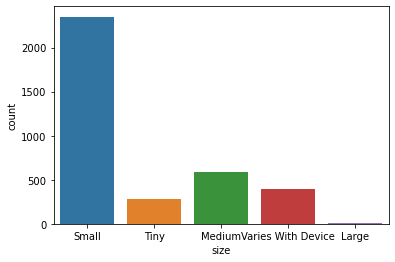

In [14]:
sns.countplot(x='size', data=data)

<AxesSubplot:xlabel='content_rating', ylabel='count'>

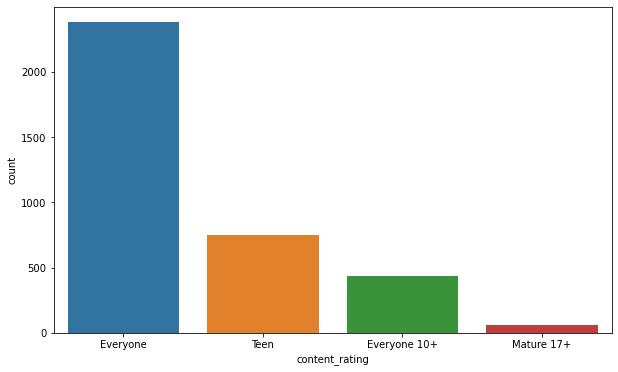

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(x='content_rating', data=data)

<AxesSubplot:xlabel='category', ylabel='count'>

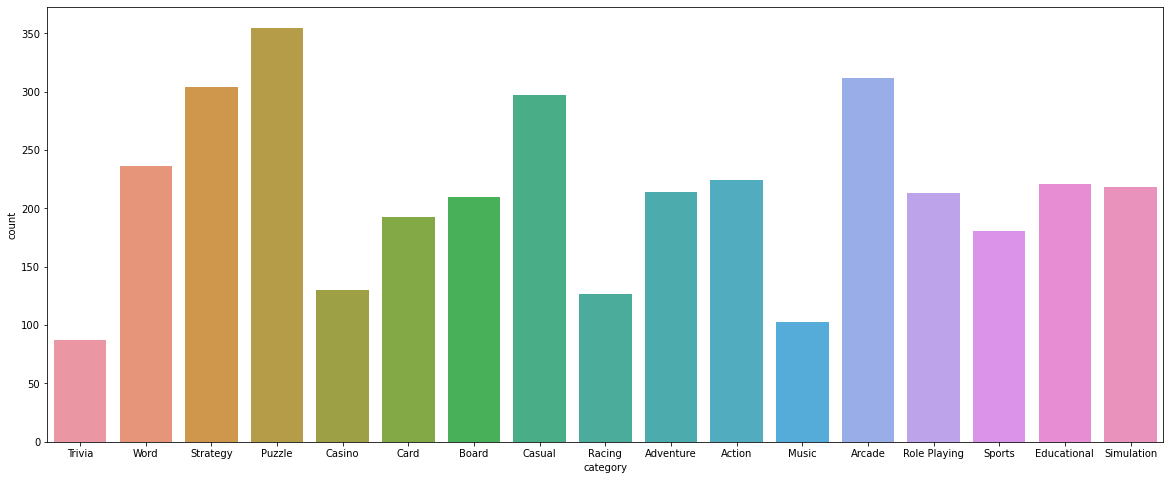

In [16]:
plt.figure(figsize=(20, 8))
sns.countplot(x='category', data=data)

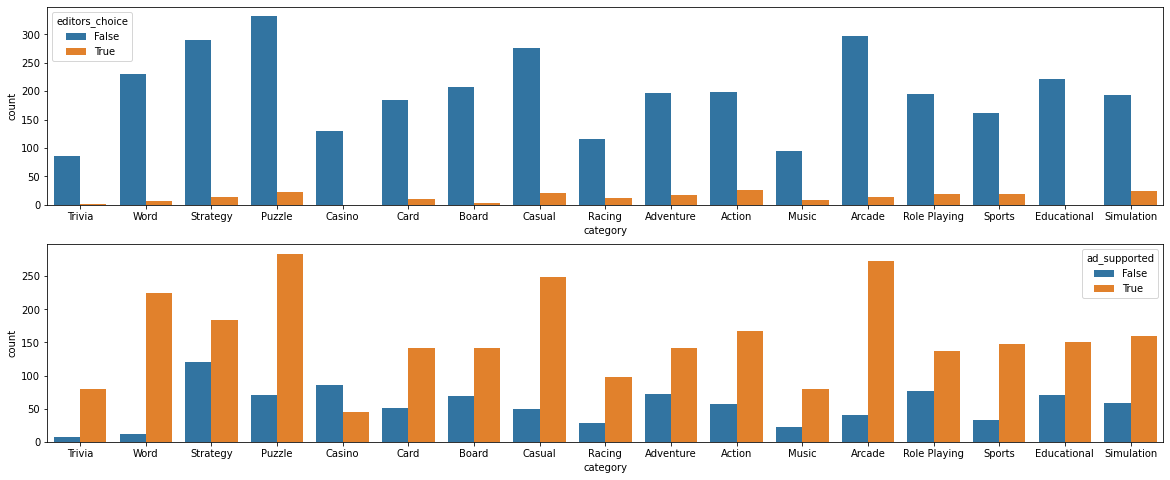

In [17]:
plt.figure(figsize=(20, 8))

plt.subplot(2, 1, 1)
sns.countplot(x='category', data=data, hue='editors_choice')

plt.subplot(2, 1, 2)
sns.countplot(x='category', data=data, hue='ad_supported')

plt.show()

In [18]:
def define_lang(row):
    text = TextBlob(row['summary'])
    iso_code = text.detect_language()
    language = pycountry.languages.get(alpha_2=iso_code)
    return language.name

In [19]:
# data['lang'] = data.apply(define_lang, 1)

In [20]:
data.tail()

,id,title,url,category,avg_rating,rating_count,price,developer_name,developer_url,description,summary,min_installs,editors_choice,size,android_version,content_rating,ad_supported,released,is_free
3622,wordgame.stacks.crush.fish,Word Games Ocean: Find Hidden Words,https://play.google.com/store/apps/details?id=...,Word,4.8,1446.0,0.0,Innovation Puzzle Games,https://play.google.com/store/apps/developer?i...,????Totally free & 1000+ levels\r\n????Collect...,????Different sea world for 2020????Rescue dro...,50000.0,False,Small,4.4,Everyone,True,"Oct 28, 2019",False
3623,wordpuzzle.innovationgames.crossword,Word Games Music - Crossword Puzzle,https://play.google.com/store/apps/details?id=...,Word,4.6,12870.0,0.0,Innovation Puzzle Games,https://play.google.com/store/apps/developer?i...,Download to train your brain with 2000+ challe...,????2021 Addictive Crossword Games! Solve CLAS...,1000000.0,False,Small,4.4,Everyone,True,"Apr 26, 2019",False
3624,world.playme.mechat,MeChat - Love secrets,https://play.google.com/store/apps/details?id=...,Role Playing,4.1,3725.0,0.0,PlayMe Studio,https://play.google.com/store/apps/developer?i...,Find your perfect match with MeChat! \r\n\r\nW...,"Swipe, Match, Date!",100000.0,False,Small,5.0,Mature 17+,True,"Jan 26, 2021",False
3625,zombie.survival.craft.z,Last Day on Earth: Survival,https://play.google.com/store/apps/details?id=...,Action,4.4,4148479.0,0.0,Kefir!,https://play.google.com/store/apps/dev?id=8784...,The survival shooter Last Day on Earth is set ...,Survive among the Dead,50000000.0,True,Varies With Device,5.0,Teen,False,"May 24, 2017",False
3626,zozo.android.crosswords,???? - ???? ????? ???????,https://play.google.com/store/apps/details?id=...,Word,4.6,748453.0,0.0,Alrazy Labs (ZoZo),https://play.google.com/store/apps/developer?i...,??? ?????? ????? ????? ????? ??? ???? ??????? ...,Game cultural comprehensive in various fields ...,5000000.0,False,Small,2.3.3,Everyone,True,"May 27, 2015",False
